### Brute force solution

In [1]:
from itertools import permutations
from math import inf
from typing import List

def brute_force_tsp(adj_matrix: List[List[int]], start: int) -> int:
    """A brute force solution for TSP to have a baseline to compare
        optimized solutions. Get all permutations, find the length of
        the permutations, and pick the permutation with the shortest 
        length. Time complexity: O(n!)
    
    Parameters
    ----------
    graph: list[list]
        An adjacency matrix that represents the graph of customer
        homes, hub locations, and the main hub.
    start: int
        Represents where the route begins
        
    Returns
    -------  
    int
        Length of shortest path
    """
    
    nodes = [] # For list of nodes excluding start node
    shortest_path_len = inf # Initialize largest possible minimum
    size = len(adj_matrix[0]) # Number of nodes
    
    for node in range(size): 
        if node != start:
            nodes.append(node)
    print(f'nodes: {nodes}')
            
    permutations_li = permutations(nodes) # Create permuations of sodes
    for permutation in permutations_li: # Iterate through all permutations
        print(f'permutation: {permutation}')
        current_path_len = 0
        k = start
        for j in permutation:
            current_path_len += adj_matrix[k][j]
            k = j
        current_path_len += adj_matrix[k][start]
        print(f'permuation path length: {current_path_len}')
        shortest_path_len = min(shortest_path_len, current_path_len)
    print(f'\nshortest path length: {shortest_path_len}')
    return shortest_path_len

matrix = [[0,10,15,20], [10,0,35,25], [15,35,0,30], [20,25,30,0]]
start = 0

brute_force_tsp(matrix, start)

### Christofides Algorithm
Steps:
1. Find minimum spanning tree (MST) of graph (G)
2. Make a set (S) of nodesthat have an odd degree in MST
3. Find a minimum cost perfect matching (PM) from S
4. Create a multigraph (MG) from the set of edges from PM to MST to form a new graph where all nodes have an even degree
5. Find a Eulerian cycle of MG
6. Remove repeated vertices from MG

##### Chrisofides compared to brute force

In [2]:
import networkx as nx
import numpy as np

# Prework: Read input as adjacency matrix
matrix_as_list = [[0,10,15,20], [10,0,35,25], [15,35,0,30], [20,25,30,0]]
adj_matrix = np.matrix(matrix_as_list)
graph = nx.from_numpy_matrix(adj_matrix)
print(f'adjacency matrix:\n {adj_matrix}')
print(f'graph nodes: {graph.nodes}')
print(f'graph edges: {graph.edges}') #TODO: WHY NOT SHOWING EDGES BEFORE 0 DIAGONAL ON MATRIX?????
nx.draw_networkx(graph, node_color='lightgreen')

adjacency matrix:
 [[ 0 10 15 20]
 [10  0 35 25]
 [15 35  0 30]
 [20 25 30  0]]
graph nodes: [0, 1, 2, 3]
graph edges: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


MST graph nodes: [0, 1, 2, 3]
MST graph edges: [(0, 1), (0, 2), (0, 3)]
MST edge count: 3


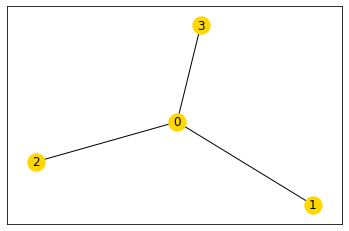

In [3]:
# Algorithm step 1. Find minimum spanning tree of the graph
MST = nx.minimum_spanning_tree(graph, weight='weight')
print(f'MST graph nodes: {MST.nodes}')
print(f'MST graph edges: {MST.edges}')
print(f'MST edge count: {MST.number_of_edges()}')
nx.draw_networkx(MST, node_color='gold')

odd degree nodes: [0, 1, 2, 3]


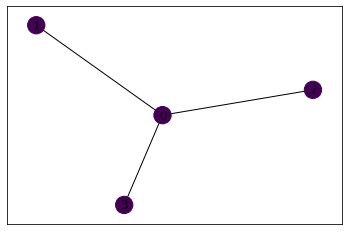

In [4]:
# Algorithm step 2. Make a set of nodes that have an odd degree in the minimum spanning tree
odd_degree_nodes = [i for i in MST.nodes if MST.degree(i) % 2 != 0]
print(f'odd degree nodes: {odd_degree_nodes}')
odd_node_colors = [MST.degree(i) % 2 for i in MST.nodes] # Make the odd degree nodes have a different color
nx.draw_networkx(MST, node_color=odd_node_colors)

perfect matching edges: {(1, 3), (0, 2)}
perfect matching edge count: 2


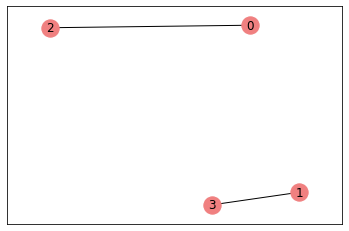

In [5]:
# Algorithm step 3. Find a minimum cost perfect matching from the set of nodes that have an odd degree
'''
Since min_weight_matching is not working, invert edge weights in 
original graph and find the maximum perfect matching of this 
transformed graph. That will be the minimum perfect matching in the
original graph.
'''
for i,j in graph.edges:
    graph.edges[i,j]['negative_weight'] = -(graph.edges[i,j]['weight'])
    
# Match only odd-degree nodes using subgraph attribute
# Get perfect matching by selecting maxcardinality
perfect_matching = nx.max_weight_matching(graph.subgraph(odd_degree_nodes), maxcardinality=True, weight='negative_weight')
print(f'perfect matching edges: {perfect_matching}')
print(f'perfect matching edge count: {len(perfect_matching)}')
nx.draw_networkx(graph.edge_subgraph(perfect_matching), node_color='lightcoral')

multigraph edges: [(0, 1), (0, 2), (0, 2), (0, 3), (1, 3)]
multigraph edge count: 5


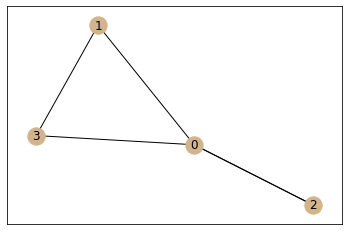

In [6]:
# Algorithm step 4. Create a multigraph from the edges from PM to MST to form a new graph
mgraph = nx.MultiGraph()
mgraph.add_nodes_from(graph.nodes)
mgraph.add_edges_from(MST.edges)
mgraph.add_edges_from(perfect_matching)
print(f'multigraph edges: {mgraph.edges()}')
print(f'multigraph edge count: {mgraph.number_of_edges()}')
nx.draw_networkx(mgraph, node_color='tan')

In [7]:
# Algorithm step 5. Find a Eulerian cycle of the multigraph
eulerian_path = list(nx.eulerian_circuit(mgraph, source=0))
print(eulerian_path)

[(0, 2), (2, 0), (0, 3), (3, 1), (1, 0)]


In [8]:
# Algorithm step 6. Remove repeated vertices from the multigraph
shortest_path_nodes = [0]
for (i,j) in eulerian_path:
    if j not in shortest_path_nodes:
        shortest_path_nodes.append(j)
print(f'shortest path nodes: {shortest_path_nodes}')

# Pair the non-repeating nodes
shortest_path_edges = [(shortest_path_nodes[i-1], shortest_path_nodes[i]) for i in range(len(graph.nodes))]
print(f'shortest path edges: {shortest_path_edges}')

shortest path nodes: [0, 2, 3, 1]
shortest path edges: [(1, 0), (0, 2), (2, 3), (3, 1)]


edge: (1, 0)
edge length: 10
edge: (0, 2)
edge length: 15
edge: (2, 3)
edge length: 30
edge: (3, 1)
edge length: 25

shortest path length: 80


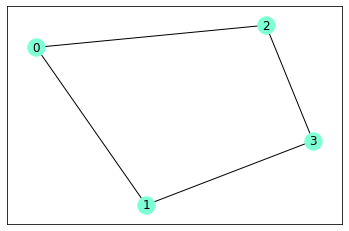

In [9]:
# Visualize the path and print_distance
nx.draw_networkx(graph.edge_subgraph(shortest_path_edges), node_color='aquamarine')

min_path_len = 0
for edge in shortest_path_edges:
    print(f'edge: {edge}')
    len = graph.edges[edge[0],edge[1]]['weight']
    print(f'edge length: {len}')
    min_path_len += len
    
print(f'\nshortest path length: {round(min_path_len, 2)}')    

##### Chrisofides with randomly generated input

Graph with 20 nodes and 190 edges
{0: (0.5521457772017092, 0.7825017568640733), 1: (0.2819869908715531, 0.684588691550291), 2: (0.4173773083413891, 0.4698583490807775), 3: (0.6504889326215637, 0.46329791189239244), 4: (0.9303527465964192, 0.9750678190403999), 5: (0.8524242307395621, 0.7067204553285733), 6: (0.4613318124439384, 0.5391115396172284), 7: (0.8556214390845325, 0.56917624866439), 8: (0.05766123495642439, 0.8161324923448028), 9: (0.03369959423842017, 0.6928955842290477), 10: (0.6494032382205202, 0.515942945058277), 11: (0.6078037635982616, 0.08178864888256299), 12: (0.604373464704962, 0.8137123454892021), 13: (0.9208247312212622, 0.4392330672614503), 14: (0.8487237715270469, 0.18375052001884917), 15: (0.1915826213334274, 0.1876019789197031), 16: (0.3803497568625831, 0.8531802407050068), 17: (0.8832882759224456, 0.8616168019610647), 18: (0.05828596185409507, 0.24869098067150586), 19: (0.8947837114596364, 0.08198843873025852)}


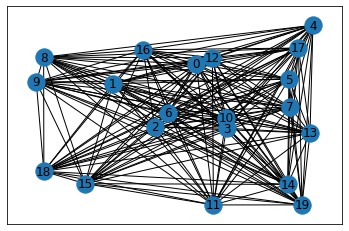

In [10]:
import random

# Prework: create input
# Complete graph with n cities
n = 20
G = nx.complete_graph(n)
print(G)
# Pick xy coordinates randomly
my_pos = {i: (random.random(), random.random()) for i in G.nodes}
print(my_pos)
nx.draw_networkx(G, pos=my_pos) #for labels: draw_networkx instead of draw

In [11]:
import math

# Prework: calculate euclidian distance of randomly generated points
def euclidian_distance(x1,y1,x2,y2):
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['length'] = euclidian_distance(x1,y1,x2,y2)

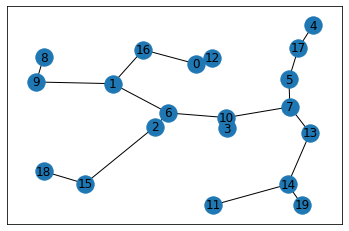

In [12]:
# Algorithm step 1. Find minimum spanning tree of the graph
T = nx.minimum_spanning_tree(G, weight='length')
nx.draw_networkx(T, pos=my_pos)

[1, 3, 4, 6, 7, 8, 10, 11, 12, 14, 18, 19]


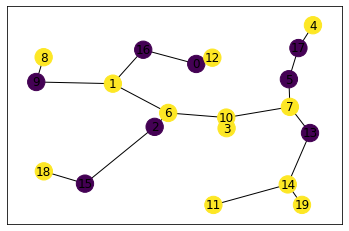

In [13]:
# Algorithm step 2. Make a set of nodes that have an odd degree in the minimum spanning tree
odd_degree_nodes = [i for i in T.nodes if T.degree(i) % 2 != 0]
print(odd_degree_nodes)
node_colors = [T.degree(i) % 2 for i in T.nodes] 
nx.draw_networkx(T, pos=my_pos, node_color=node_colors)

{(4, 7), (8, 1), (12, 6), (19, 14), (18, 11), (10, 3)}


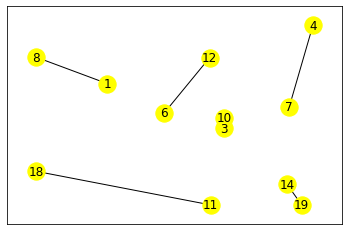

In [14]:
# Algorithm step 3. Find a minimum cost perfect matching from the set of nodes that have an odd degree
# NOTE: It will always be an even number of odd-degree nodes, so 
#      perfect matching works

# Since min_weight_matching is not working, invert edge weights in 
# original graph and find the maximum perfect matching of this 
# transformed graph. That will be the minimum perfect matching in the
# original graph.

for i,j in G.edges:
    G.edges[i,j]['negative_length'] = -(G.edges[i,j]['length'])

# Match only odd-degree nodes using subraph
# Perfect matching by selecting maxcardinality
matching = nx.max_weight_matching(G.subgraph(odd_degree_nodes), maxcardinality=True, weight='negative_length')
print(matching)
nx.draw_networkx(G.edge_subgraph(matching), pos=my_pos, node_color='yellow')

[(0, 12), (0, 16), (1, 16), (1, 6), (1, 9), (1, 8), (2, 6), (2, 15), (3, 10), (3, 10), (4, 17), (4, 7), (5, 7), (5, 17), (6, 10), (6, 12), (7, 13), (7, 10), (8, 9), (11, 14), (11, 18), (13, 14), (14, 19), (14, 19), (15, 18)]
number of edges: 25


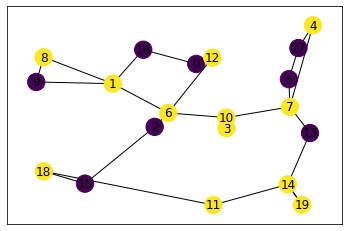

In [15]:
# Algorithm step 4. Create a multigraph from the edges from PM to MST to form a new graph
mgraph = nx.MultiGraph()
mgraph.add_nodes_from(range(n))

mgraph.add_edges_from(T.edges())
mgraph.add_edges_from(matching)
nx.draw_networkx(mgraph, pos=my_pos, node_color=node_colors)
print(mgraph.edges())
print(f'number of edges: {mgraph.number_of_edges()}')

In [16]:
# Algorithm step 5. Find a Eulerian cycle of the multigraph
'''Guaranteed to exist bc of the multigraph - so all nodes have even 
degree and its connected bc of MST''' 
eulerian_path = list(nx.eulerian_circuit(mgraph, source=0))
print(eulerian_path)

[(0, 16), (16, 1), (1, 8), (8, 9), (9, 1), (1, 6), (6, 10), (10, 3), (3, 10), (10, 7), (7, 5), (5, 17), (17, 4), (4, 7), (7, 13), (13, 14), (14, 19), (19, 14), (14, 11), (11, 18), (18, 15), (15, 2), (2, 6), (6, 12), (12, 0)]


In [17]:
# Algorithm step 6. Remove repeated vertices from the multigraph
shortest_path_nodes = [0]
for (i,j) in eulerian_path:
    if j not in shortest_path_nodes:
        shortest_path_nodes.append(j)
print(shortest_path_nodes)

# pair the non-repeating nodes
shortest_path_edges = [(shortest_path_nodes[i-1],shortest_path_nodes[i]) for i in range(n)]
print(shortest_path_edges)

[0, 16, 1, 8, 9, 6, 10, 3, 7, 5, 17, 4, 13, 14, 19, 11, 18, 15, 2, 12]
[(12, 0), (0, 16), (16, 1), (1, 8), (8, 9), (9, 6), (6, 10), (10, 3), (3, 7), (7, 5), (5, 17), (17, 4), (4, 13), (13, 14), (14, 19), (19, 11), (11, 18), (18, 15), (15, 2), (2, 12)]


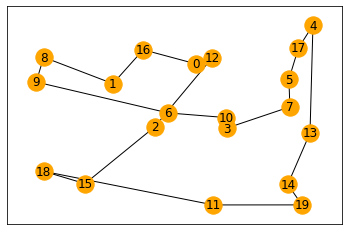

In [18]:
# Visualize the shortest path subgraph and print_distance
nx.draw_networkx(G.edge_subgraph(shortest_path_edges), pos=my_pos, node_color='orange')

In [19]:
# Print distance of shortest path subgraph
min_path_len = 0
for edge in shortest_path_edges:
    print(edge)
#     print(edge[0])
#     print(edge[1])
    len = G.edges[edge[0],edge[1]]['length']
    print(len)
    min_path_len += len
#     print(min_path_len)
    
print(round(min_path_len, 2))

(12, 0)
0.06084268390089682
(0, 16)
0.1857668449492926
(16, 1)
0.19518797140139826
(1, 8)
0.2600496419808343
(8, 9)
0.12554479578154473
(9, 6)
0.45444344689360633
(6, 10)
0.18949312643859503
(10, 3)
0.05265622707115978
(3, 7)
0.23084533221484996
(7, 5)
0.1375813611216313
(5, 17)
0.15794134191257211
(17, 4)
0.12282588357572238
(4, 13)
0.5359194569065372
(13, 14)
0.2654616362761195
(14, 19)
0.11170066810355023
(19, 11)
0.28698001740626583
(11, 18)
0.5743049736771635
(18, 15)
0.14662832456036876
(15, 2)
0.36145801855475396
(2, 12)
0.3914117184510381
4.85
